In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***#找到可以Training 的最終模型***

In [ ]:
#915 / 90
df2 = pd.read_csv('/content/drive/MyDrive/1112DL作業/Netflix_Lags_3.csv')
df2.round(2)

,Date,Close,close_Lag1,close_Lag2,close_Lag3
0,2019-05-23,352.21,359.73,354.27,348.11
1,2019-05-24,354.39,352.21,359.73,354.27
2,2019-05-28,355.06,354.39,352.21,359.73
3,2019-05-29,349.19,355.06,354.39,352.21
4,2019-05-30,351.85,349.19,355.06,354.39
...,...,...,...,...,...
1000,2023-05-12,339.89,344.76,335.42,332.14
1001,2023-05-15,335.89,339.89,344.76,335.42
1002,2023-05-16,333.75,335.89,339.89,344.76
1003,2023-05-17,339.96,333.75,335.89,339.89


In [ ]:
Forecast_train_data=df2.iloc[0:909+1,:].copy()
Forecast_train_data

#資料編號 0 - 909（2019.May.18 - 2022.Dec）

,Date,Close,close_Lag1,close_Lag2,close_Lag3
0,2019-05-23,352.209991,359.730011,354.269989,348.109985
1,2019-05-24,354.390015,352.209991,359.730011,354.269989
2,2019-05-28,355.059998,354.390015,352.209991,359.730011
3,2019-05-29,349.190002,355.059998,354.390015,352.209991
4,2019-05-30,351.850006,349.190002,355.059998,354.390015
...,...,...,...,...,...
905,2022-12-23,294.959991,297.750000,297.959991,288.190002
906,2022-12-27,284.170013,294.959991,297.750000,297.959991
907,2022-12-28,276.880005,284.170013,294.959991,297.750000
908,2022-12-29,291.119995,276.880005,284.170013,294.959991


In [ ]:
Forecast_test_data=df2.iloc[910:1004+1,:].copy()
Forecast_test_data

#資料編號 910 - 1004（2023.Jan - 2023.May.18）

,Date,Close,close_Lag1,close_Lag2,close_Lag3
910,2023-01-03,294.950012,294.880005,291.119995,276.880005
911,2023-01-04,309.410004,294.950012,294.880005,291.119995
912,2023-01-05,309.700012,309.410004,294.950012,294.880005
913,2023-01-06,315.549988,309.700012,309.410004,294.950012
914,2023-01-09,315.170013,315.549988,309.700012,309.410004
...,...,...,...,...,...
1000,2023-05-12,339.890015,344.760010,335.420013,332.140015
1001,2023-05-15,335.890015,339.890015,344.760010,335.420013
1002,2023-05-16,333.750000,335.890015,339.890015,344.760010
1003,2023-05-17,339.959991,333.750000,335.890015,339.890015


In [ ]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [ ]:
x_forecast_train

,close_Lag1,close_Lag2,close_Lag3
0,359.730011,354.269989,348.109985
1,352.209991,359.730011,354.269989
2,354.390015,352.209991,359.730011
3,355.059998,354.390015,352.209991
4,349.190002,355.059998,354.390015
...,...,...,...
905,297.750000,297.959991,288.190002
906,294.959991,297.750000,297.959991
907,284.170013,294.959991,297.750000
908,276.880005,284.170013,294.959991


In [ ]:
y_forecast_train

0      352.209991
1      354.390015
2      355.059998
3      349.190002
4      351.850006
          ...    
905    294.959991
906    284.170013
907    276.880005
908    291.119995
909    294.880005
Name: Close, Length: 910, dtype: float64

In [ ]:
#my_rmse
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

In [ ]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add forth hidden layer
#Fmodel.add(Dense(units=48, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

#opt=Adam(learning_rate=0.05,beta_1=0.005)
#opt=Adam(learning_rate=0.1,beta_1=0.005)
#opt=Adam(learning_rate=0.05,beta_1=0.5)
#opt=Adam(learning_rate=0.1,beta_1=0.005)
#opt=Adam(learning_rate=0.1,beta_1=0.5)
#opt=Adam(learning_rate=0.05,beta_1=0.5)
#opt=Adam(learning_rate=0.001,beta_1=0.005)
#opt=Adam(learning_rate=0.001,beta_1=0.5)
#opt=Adam(learning_rate=0.001,beta_1=0.005)
opt=Adam(learning_rate=0.001,beta_1=0.9)
#opt=Adam(learning_rate=0.001,beta_1=0.005)
#opt=Adam(learning_rate=0.1,beta_1=0.9)

Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
15/15 [==============================] - 1s 2ms/step - loss: 382.9739 - mean_absolute_percentage_error: 93.2988
Epoch 2/300
15/15 [==============================] - 0s 2ms/step - loss: 299.9799 - mean_absolute_percentage_error: 72.9512
Epoch 3/300
15/15 [==============================] - 0s 2ms/step - loss: 214.6298 - mean_absolute_percentage_error: 52.1508
Epoch 4/300
15/15 [==============================] - 0s 2ms/step - loss: 99.6234 - mean_absolute_percentage_error: 24.1967
Epoch 5/300
15/15 [==============================] - 0s 2ms/step - loss: 22.1054 - mean_absolute_percentage_error: 5.5701
Epoch 6/300
15/15 [==============================] - 0s 2ms/step - loss: 12.5098 - mean_absolute_percentage_error: 3.2442
Epoch 7/300
15/15 [==============================] - 0s 2ms/step - loss: 11.0192 - mean_absolute_percentage_error: 2.9173
Epoch 8/300
15/15 [==============================] - 0s 2ms/step - loss: 10.0333 - mean_absolute_percentage_error: 2.6788
Epoch 9/300
15/15

# ***TESTING***

In [ ]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [ ]:
# 8.1 Make prediction - Model1
prediction=np.round((Fmodel.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
910,2023-01-03,294.950012,296.589996,1.639984
911,2023-01-04,309.410004,296.390015,13.019989
912,2023-01-05,309.700012,307.940002,1.760010
913,2023-01-06,315.549988,311.410004,4.139984
914,2023-01-09,315.170013,316.980011,1.809998
...,...,...,...,...
1000,2023-05-12,339.890015,345.380005,5.489990
1001,2023-05-15,335.890015,341.489990,5.599975
1002,2023-05-16,333.750000,337.160004,3.410004
1003,2023-05-17,339.959991,335.049988,4.910003


In [ ]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 5.957
MSE: 68.707
RMSE: 8.289
MAPE: 1.791 %
SMAPE: 1.796 %
RAE: 0.37
MRAE: 0.0038987640153870335
MdRAE: 0.35 bench: 331.872
RSE: 0.175
RRSE: 0.418


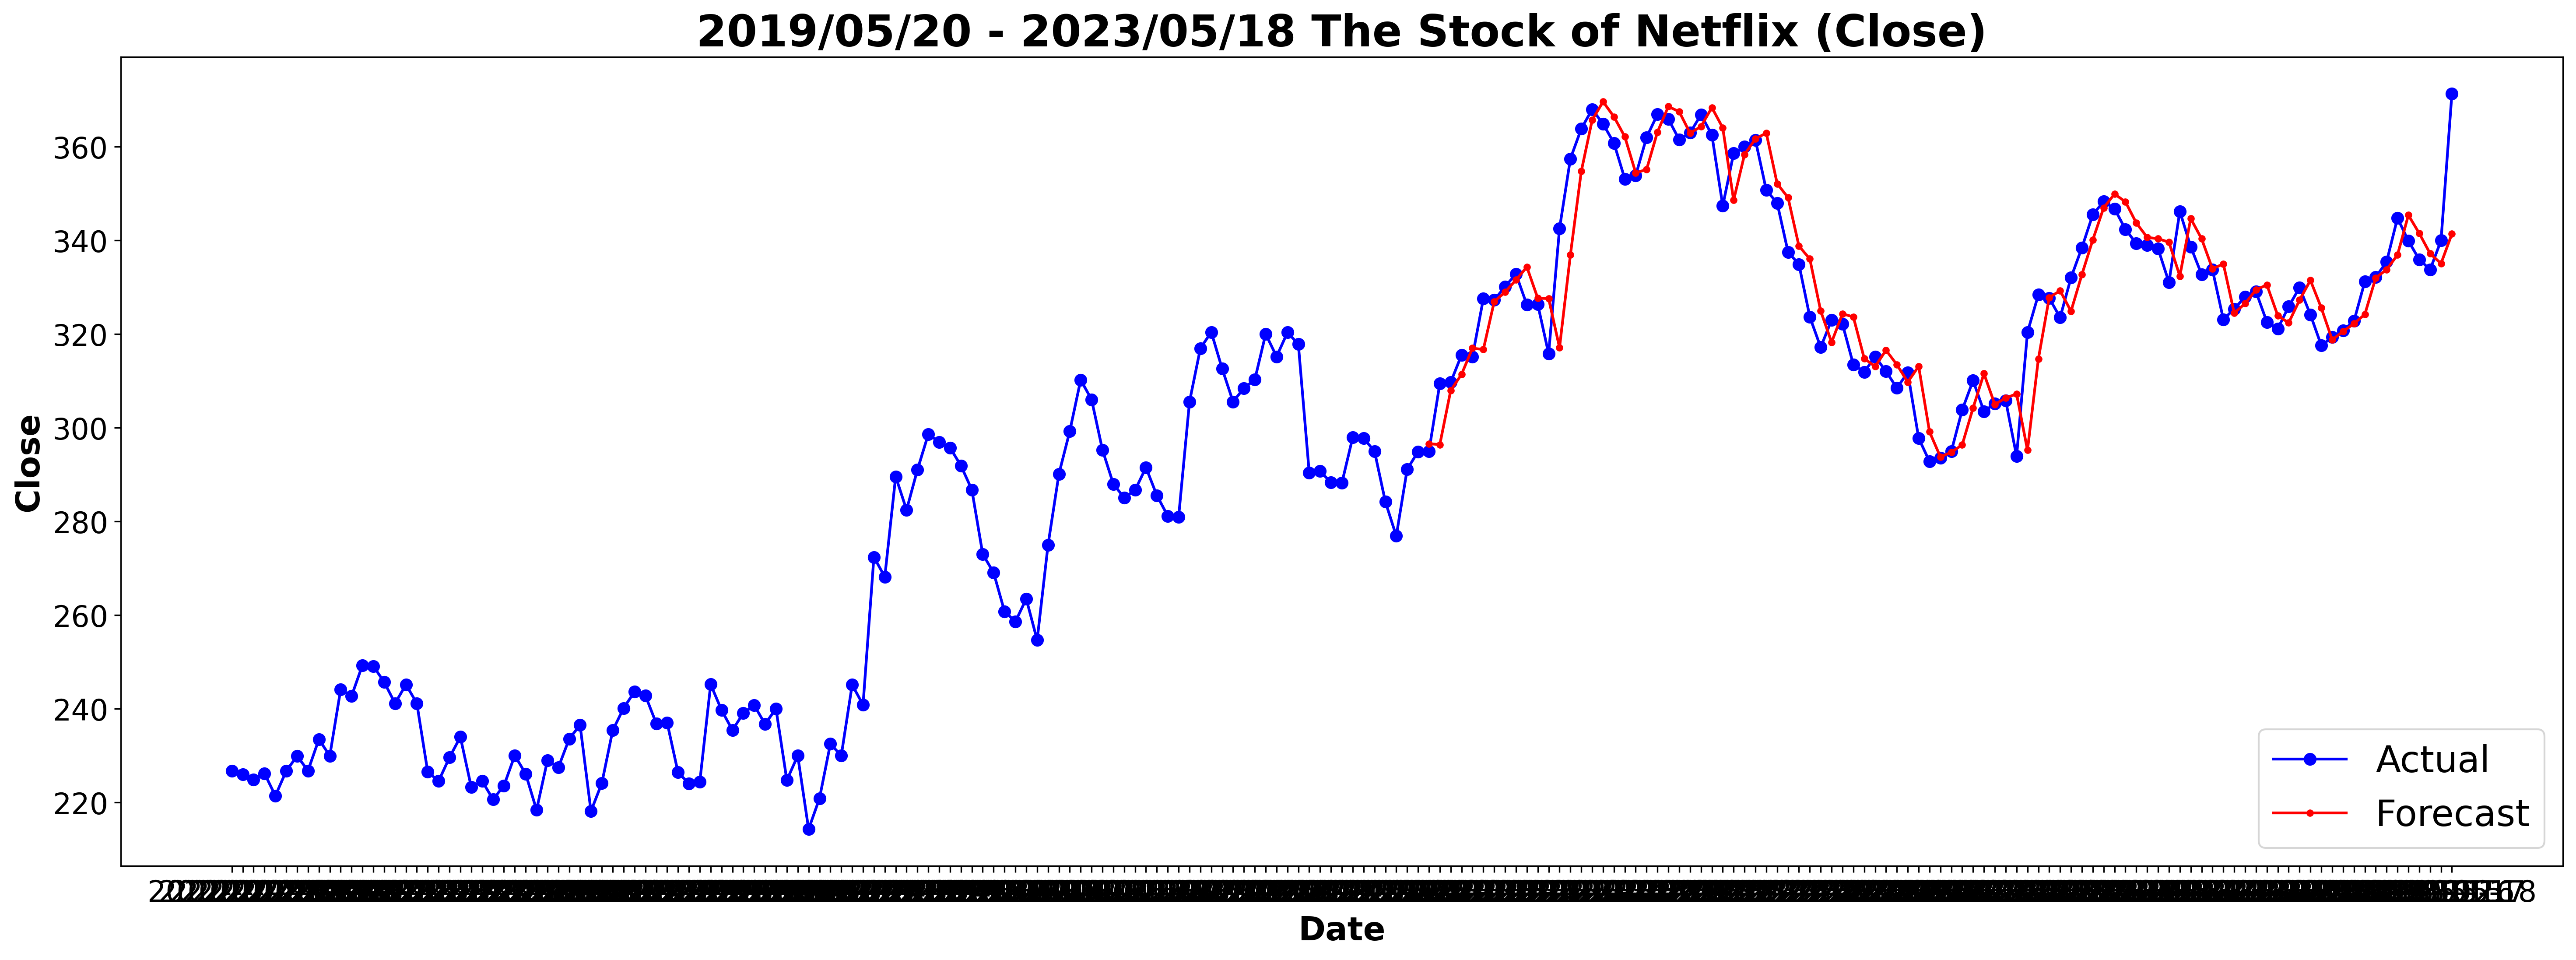

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('2019/05/20 - 2023/05/18 The Stock of Netflix (Close)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(df2.iloc[800:,0],df2.iloc[800:,1],marker='o',color='blue',label='Actual')
#plt.plot(df2['Date'],df2['Close'],marker='.',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='.',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

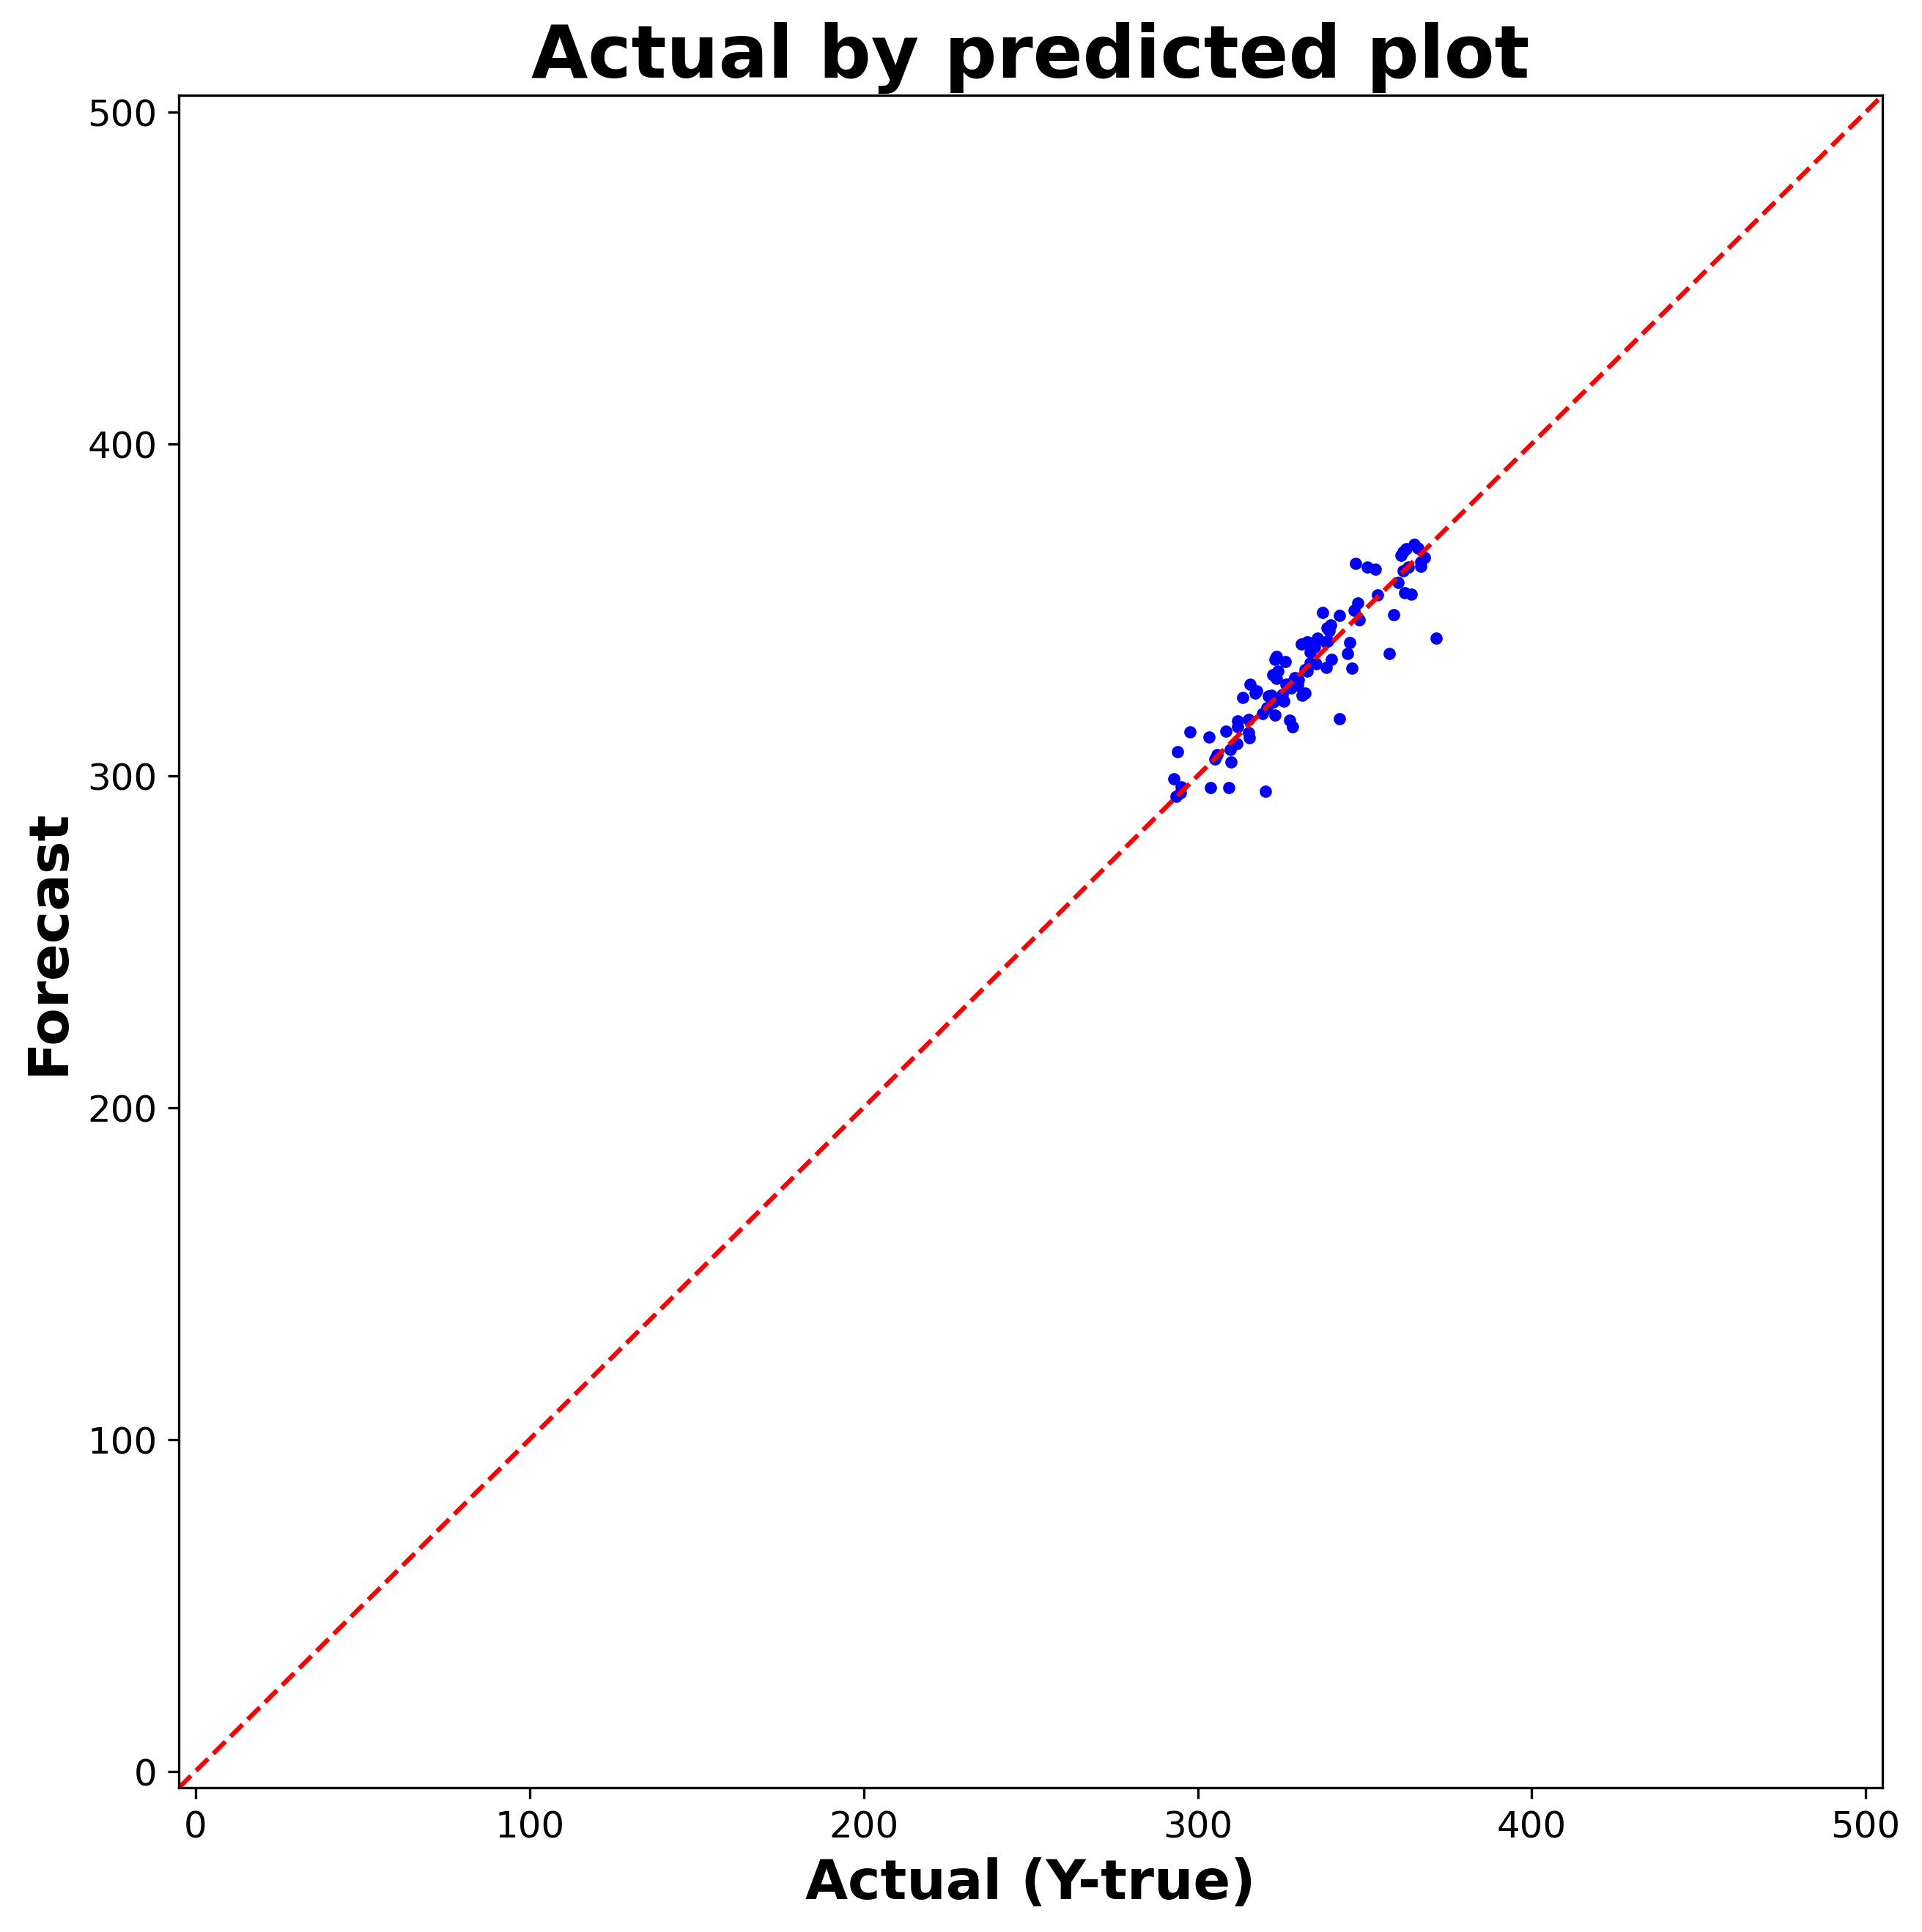

In [ ]:
# Lock the scale of axis by Y_true
max_value=500+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()